In [1]:
import os, sys
from collections import defaultdict
from tqdm import tqdm
import time

In [8]:
import gymnasium as gym
import text_flappy_bird_gym
from flappy_bird_gymnasium import *
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class MonteCarlo:
    def __init__(self, gamma, epsilon=0.1):
        """
        Initialize the Monte Carlo agent.

        Args:
            env (gym.Env): The environment to use.
            gamma (float): The discount factor.
            n_episodes (int): The number of episodes to train for.
            epsilon (float): The probability of selecting a random action.
        """
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: 0)
        self.N = defaultdict(lambda: 0)
    
    def choose_action(self, state):
        """
        Choose an action to take given a state.

        Args:
            state: The current state.

        Returns:
            The chosen action.
        """
        
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(2)
        else:
            return np.argmax([self.Q[(state,0)],self.Q[(state,1)]])

    def update_Q(self, episode):
        """
        Update the Q values given an episode.

        Args:
            episode: The episode to use for updating.

        Returns:
            None.
        """
        
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            if (state, action) not in visited:
                self.N[(state, action)] += 1
                self.Q[(state, action)] += (G - self.Q[state, action]) / self.N[state, action]
                visited.add((state, action))
    
    def train(self,env, n_episodes):
        """Train the agent (include both exploration and exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list) : list of the scores obtained for each episode
        """
        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode = []
            episode_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward,done,_, info = env.step(action)
                episode.append((state, action, reward))
                episode_reward += reward
                state = next_state
            self.update_Q(episode)
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores  
    
    def test(self,env, n_episodes):
        """Test the agent (include only exploitation)
        Args:
            env (gym.env): the environment
            num_episodes (int): the number of episodes to train the agent on
            
        Returns:
            rewards (list): list of the sum of rewards obtained for each episode
            scores (list): list of the scores obtained for each episode
        """
        rewards = []
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = np.argmax([self.Q[state,0],self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                episode_reward += reward
                state = next_state
                if info['score'] >1e5: #Stopping condition to avoid it to be stuck if it never dies
                    break
            rewards.append(episode_reward)
            scores.append(info['score'])
        return rewards,scores

100%|██████████| 10000/10000 [00:07<00:00, 1261.35it/s]


Average reward over 10000 train episodes: 21.4216
Median reward over 10000 train episodes: 13.0
Average scores over 10000 train episodes: 0.9188
Median scores over 10000 train episodes: 0.0


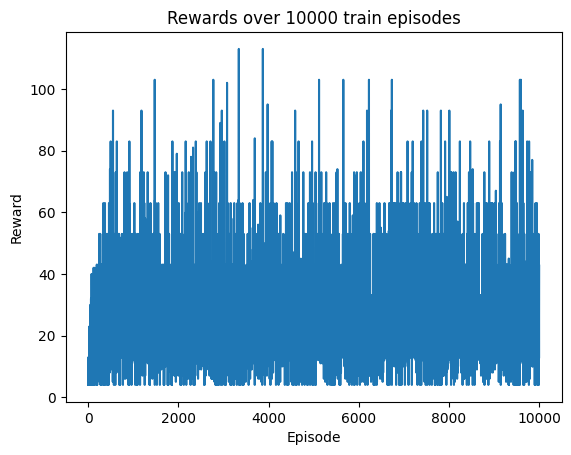

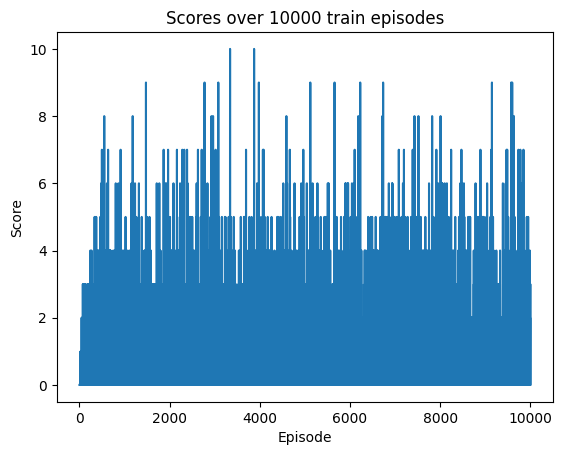

In [4]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 10000
# create the Monte Carlo agent
mc_agent = MonteCarlo(gamma=0.5, epsilon=0.5)

# train the Monte Carlo agent
train_rewards, train_scores = mc_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

In [5]:
labels = ["epsilon = 0.1", "epsilon = 0.2","epsilon = 0.3", "epsilon = 0.4","epsilon = 0.5", "epsilon = 0.6", "epsilon = 0.7"]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.7]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for eps in epsilon:
    n_episodes = 10000
    # create the Monte Carlo agent
    mc_agent = MonteCarlo(gamma=0.5, epsilon=eps)

    # train the Monte Carlo agent
    train_rewards, train_scores = mc_agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:05<00:00, 1687.05it/s]


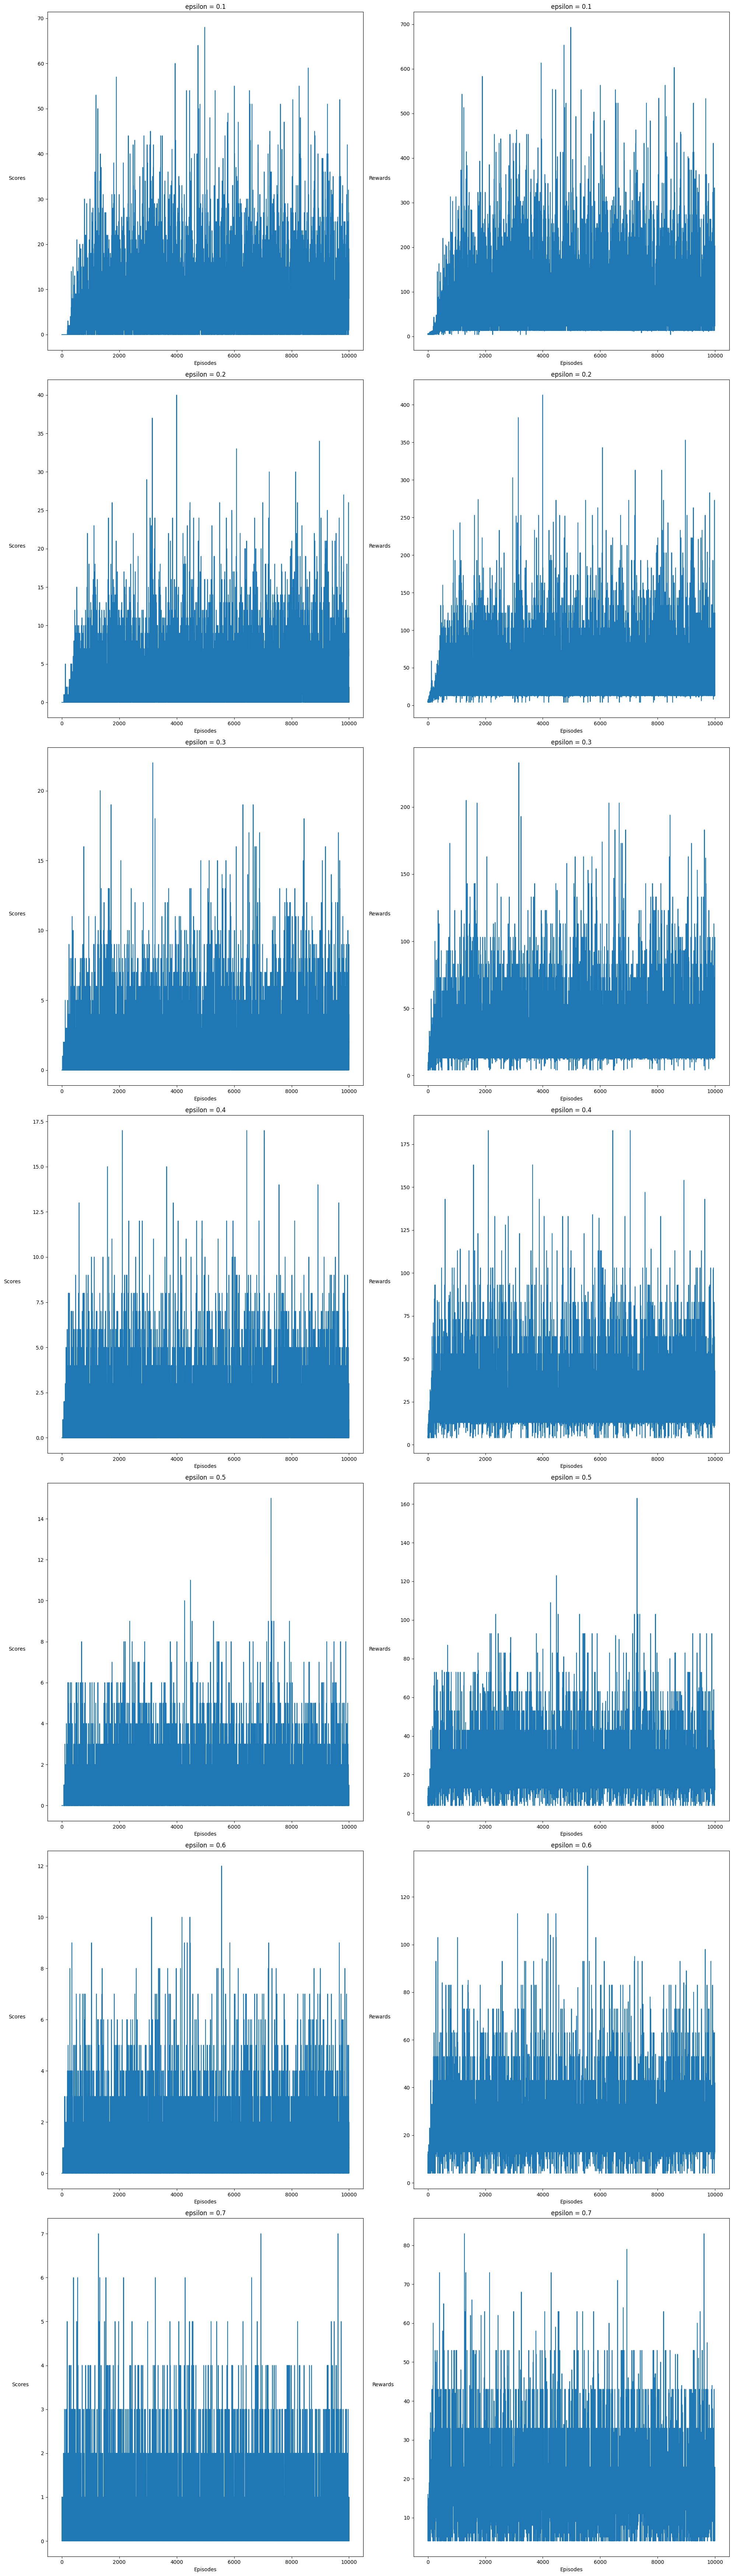

In [6]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("Episodes")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [9]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒═══════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label         │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞═══════════════╪═════════════════╪═══════════════════╪════════════════╡
│ epsilon = 0.1 │         79.7784 │                53 │            693 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.2 │         45.145  │                33 │            413 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.3 │         31.293  │                23 │            233 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.4 │         26.0606 │                23 │            183 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.5 │         21.2891 │                13 │            163 │
├───────────────┼─────────────────┼───────────────────┼────────────────┤
│ epsilon = 0.6 │         21.2027 │                

In [10]:
labels = ["Gamma = 0.5", "Gamma = 0.6", "Gamma = 0.7","Gamma = 0.8","Gamma = 0.9","Gamma = 0.9999"]
gamma = [0.5, 0.6, 0.7,0.8,0.9,0.9999]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

all_scores=[]
all_rewards=[]
for gam in gamma:
    n_episodes = 10000
    # create the Monte Carlo agent
    mc_agent = MonteCarlo(gamma=gam, epsilon=0.1)

    # train the Monte Carlo agent
    train_rewards, train_scores = mc_agent.train(env,n_episodes)
    all_scores.append(train_scores)
    all_rewards.append(train_rewards)

100%|██████████| 10000/10000 [00:12<00:00, 775.07it/s]


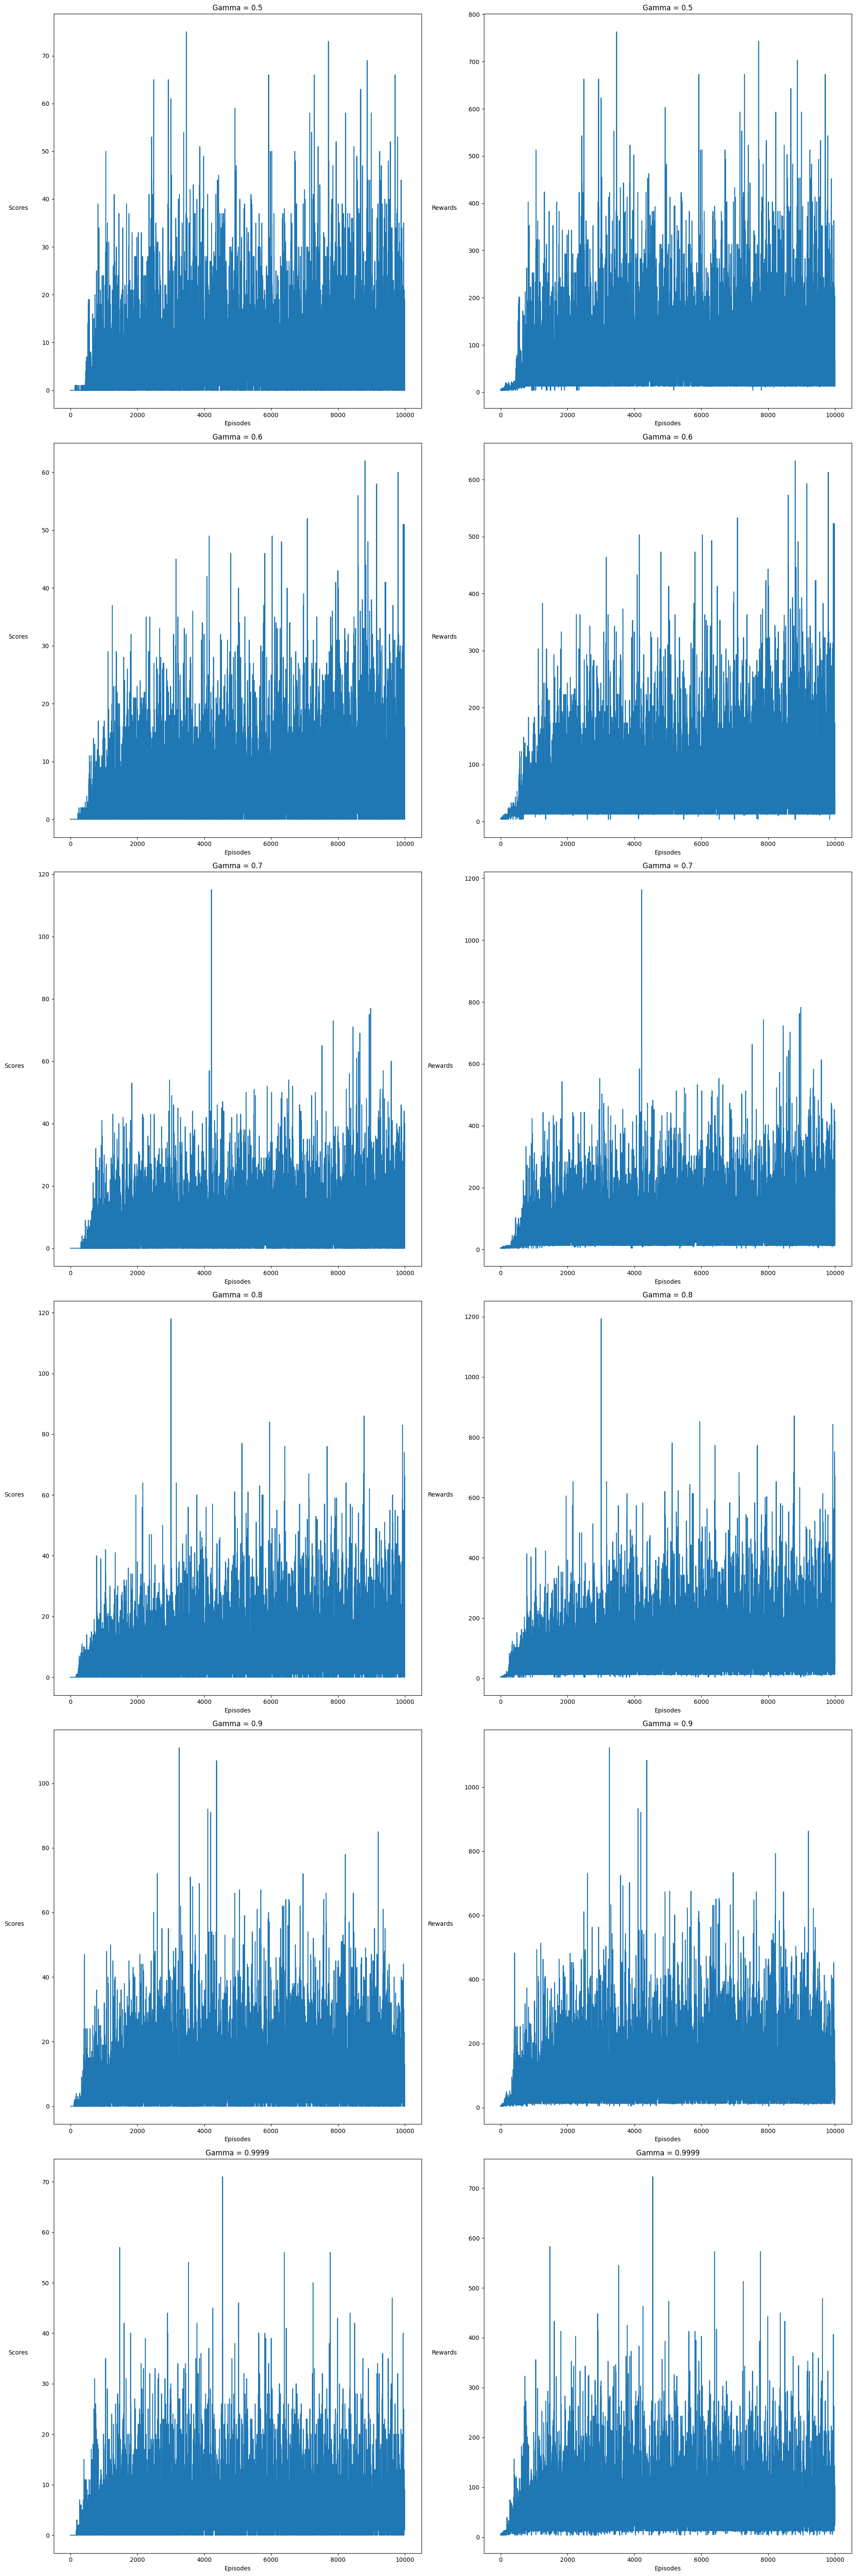

In [11]:
# Define the number of rows and columns
num_rows = len(labels)
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10*num_rows))

# Plot the scores and rewards for each row
for i in range(num_rows):
    # Plot the scores
    axs[i, 0].plot(all_scores[i])
    axs[i, 0].set_xlabel("Episodes")
    axs[i, 0].set_ylabel("Scores", rotation=0, labelpad=40)
    axs[i, 0].set_title(labels[i])

    # Plot the rewards
    axs[i, 1].plot(all_rewards[i])
    axs[i, 1].set_xlabel("Episodes")
    axs[i, 1].set_ylabel("Rewards", rotation=0, labelpad=40)
    axs[i, 1].set_title(labels[i])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plots
plt.show()

In [12]:
headers = ["Label", "Mean(Rewards)", "Median(Rewards)", "Max(Rewards)"]
rows = []

for i in range(len(all_rewards)):
    label = labels[i]
    mean = np.mean(all_rewards[i])
    median = np.median(all_rewards[i])
    maximum = np.max(all_rewards[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)


headers = ["Label", "Mean(Scores)", "Median(Scores)", "Max(Scores)"]
rows = []
for i in range(len(all_scores)):
    label = labels[i]
    mean = np.mean(all_scores[i])
    median = np.median(all_scores[i])
    maximum = np.max(all_scores[i])
    rows.append([label, mean, median, maximum])

table = tabulate(rows, headers=headers,tablefmt='fancy_grid')
print(table)

╒════════════════╤═════════════════╤═══════════════════╤════════════════╕
│ Label          │   Mean(Rewards) │   Median(Rewards) │   Max(Rewards) │
╞════════════════╪═════════════════╪═══════════════════╪════════════════╡
│ Gamma = 0.5    │         83.1304 │                55 │            763 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.6    │         69.5047 │                44 │            633 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.7    │         87.2512 │                63 │           1163 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.8    │         99.661  │                71 │           1193 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.9    │        102.212  │                73 │           1123 │
├────────────────┼─────────────────┼───────────────────┼────────────────┤
│ Gamma = 0.9999 │         63.8677 │  

100%|██████████| 20000/20000 [00:59<00:00, 334.95it/s]


Average reward over 20000 train episodes: 120.05725
Median reward over 20000 train episodes: 83.0
Average scores over 20000 train episodes: 10.80675
Median scores over 20000 train episodes: 7.0


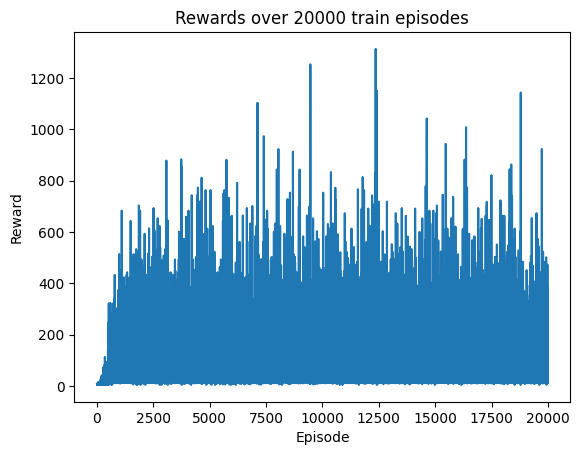

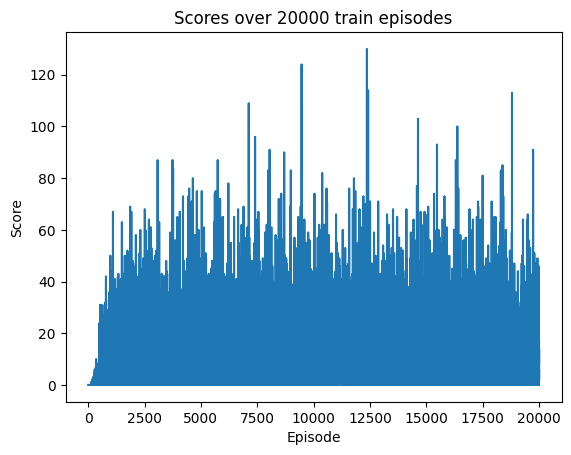

In [13]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)


n_episodes = 20000
# create the Monte Carlo agent
mc_agent = MonteCarlo(gamma=0.9, epsilon=0.1)

# train the Monte Carlo agent
train_rewards, train_scores = mc_agent.train(env,n_episodes)

print(f"Average reward over {n_episodes} train episodes:", np.mean(train_rewards))
print(f"Median reward over {n_episodes} train episodes:", np.median(train_rewards))
print(f"Average scores over {n_episodes} train episodes:", np.mean(train_scores))
print(f"Median scores over {n_episodes} train episodes:", np.median(train_scores))


# plot the rewards
plt.plot(train_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.show()

# plot the scores
plt.plot(train_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} train episodes")
plt.show()

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Average reward over 10 test episodes: 35135.0
Median reward over 10 test episodes: 15662.0
Average scores over 10 test episodes: 3512.8
Median scores over 10 test episodes: 1565.5


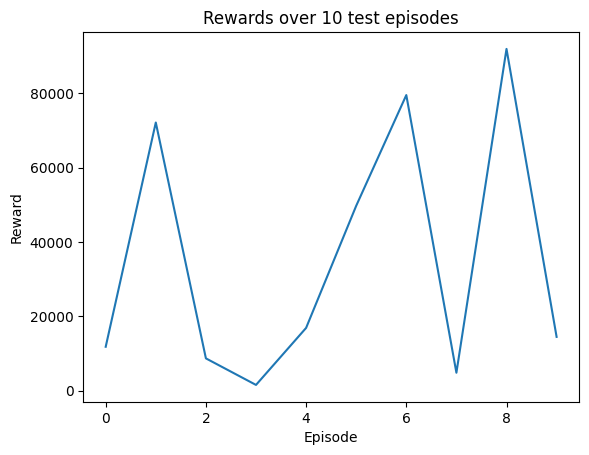

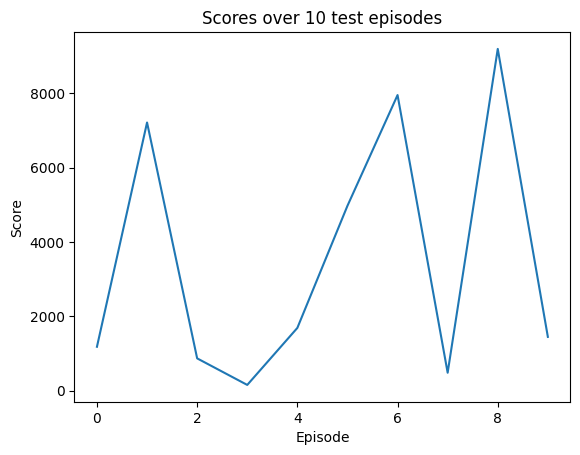

In [14]:
# test the trained agent for 10 episodes
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_episodes=10
test_rewards,test_scores = mc_agent.test(env,n_episodes)
print(f"Average reward over {n_episodes} test episodes:", np.mean(test_rewards))
print(f"Median reward over {n_episodes} test episodes:", np.median(test_rewards))
print(f"Average scores over {n_episodes} test episodes:", np.mean(test_scores))
print(f"Median scores over {n_episodes} test episodes:", np.median(test_scores))


# plot the rewards
plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} test episodes")
plt.show()

# plot the scores
plt.plot(test_scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Scores over {n_episodes} test episodes")
plt.show()